# Coursera Data Science Capstone Proj

##### This notebook will be used primarily for my final project in Data Science from the IBM course

In [2]:
import pandas as pd
import numpy as np

In [2]:
print("Hello capstone project course!")

Hello capstone project course!


### Toronto Neighborhoods Dataframe

Read in table from Wikipedia into dataframe

In [3]:
wikiurl = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
        

In [28]:
df1 = pd.read_html(wikiurl)
df1[0]
df = pd.DataFrame(df1[0])
df.head()

,Postal Code,Borough,Neighborhood
0,M1A,Not assigned,NaN
1,M2A,Not assigned,NaN
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


Remove rows where there is no borough assigned.

In [29]:
df=df[df.Borough != 'Not assigned']
df.shape

(103, 3)

Fix indexes

In [30]:
df.reset_index(inplace=True)

In [31]:
df.drop(['index'], axis = 1, inplace=True)
df.head()


,Postal Code,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


Replace missing Neighborhood values with their corresponding Borough value.

In [37]:
for i in range(df.shape[0]):
    if df["Neighborhood"][i] == np.nan:
        df["Neighborhood"][i] = df["Borough"][i]

In [43]:
df['Postal Code'].count()

103

In [46]:
df.shape

(103, 3)

#### Read in the latitude and longitudes for the different postal codes

In [47]:
locations = pd.read_csv('http://cocl.us/Geospatial_data')
locations.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


Combine dataframes so it is all in one.

In [60]:
newdf = df.merge(locations, on = "Postal Code")
newdf.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


#### Make some maps!

In [62]:
import json
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    openssl-1.1.1g             |       h516909a_0         2.1 MB  conda-forge
    altair-4.1.0               |             py_1         614 KB  conda-forge
    ca-certificates-2020.4.5.1 |       hecc5488_0         146 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    branca-0.4.1               |             py_0          26 KB  conda-forge
    certifi-2020.4.5.1         |   py36h9f0ad1d_0         151 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    ------------------------------------------------------------
                       

Run k-means to cluster the neighborhoods.

In [67]:
kclusters = 5
toronto_grouped = newdf.drop(["Postal Code","Borough", "Neighborhood"], axis=1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([4, 4, 2, 3, 2, 1, 0, 4, 4, 2], dtype=int32)

Make new df that includes cluster labels.

In [78]:
newdf.drop(["Cluster Labels"], 1, inplace = True)  #this is just extra code because I kept messing up my Cluster label column.
newdf.head(1)

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656


In [79]:
# add clustering labels
newdf.insert(5,'Cluster Labels', kmeans.labels_)

newdf.head() # check the last columns!

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Cluster Labels
0,M3A,North York,Parkwoods,43.753259,-79.329656,4
1,M4A,North York,Victoria Village,43.725882,-79.315572,4
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,2
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,3
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,2


Map clusters.

In [81]:
# create map
lat = 43.6532
long = -79.3832
map_clusters = folium.Map(location=[lat, long], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(newdf['Latitude'], newdf['Longitude'], newdf['Postal Code'], newdf['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

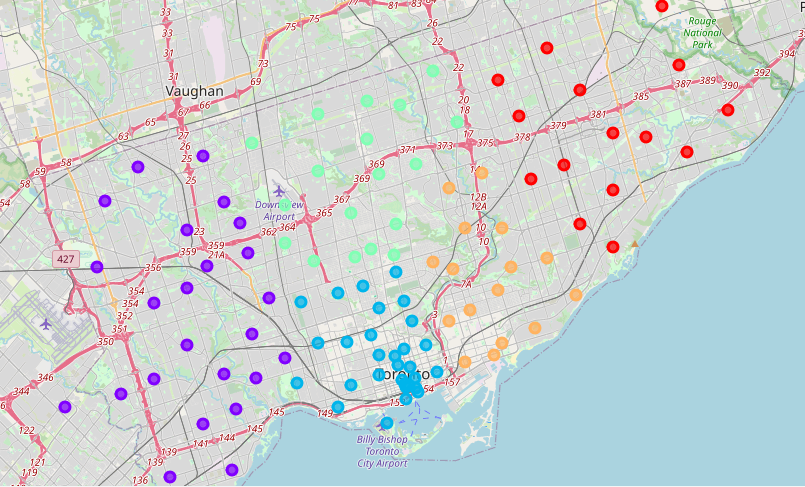

For some reason the map won't display when I put this on Github (even though I have made it a trusted file), so here is an image of it instead.